In [1]:
import sys
import pathlib
import datetime
import xarray as xr
import cftime
import variables
import pandas as pd
import re
import dask
import numpy as np
import os
from cluster import PerlmutterSLURMCluster
from process_files import glob_nc_files, process_case, memory, open_compress_and_save_file, compute_anomalies, set_coords, add_additional_coords, expand_ensemble_dims, set_encoding, save_to_netcdf
import tqdm

In [2]:
scratch = pathlib.Path(os.environ['SCRATCH']) / 'dor'
dask_log_directory = pathlib.Path(os.environ['SCRATCH']) / 'dask' / 'logs'
dask_local_directory = pathlib.Path(os.environ['SCRATCH']) / 'dask' / 'local-dir'

scratch.mkdir(parents=True, exist_ok=True)
dask_local_directory.mkdir(parents=True, exist_ok=True)
dask_log_directory.mkdir(parents=True, exist_ok=True)

In [3]:
n_workers = 1 # Number of Slurm jobs to launch in parallel
n_nodes_per_calc = 1 # Number of nodes to reserve for each Slurm job
n_cores_per_node = 48 # Number of CPU cores per node
mem_per_node = "512 GB" # Total memory per node
cluster_kwargs = {
 
    # Dask worker options
    "processes" : n_cores_per_node,
    "cores": n_cores_per_node, # total number of cores (per Slurm job) for Dask worker
    "memory": mem_per_node, # total memory (per Slurm job) for Dask worker
    
    # SLURM options
    "job_name" : 'dor-dataset-compression',
    "shebang": "#!/bin/bash",
    "walltime": "00:30:00", # DD:HH:SS
    "job_mem": "0", # all memory on node
    "job_script_prologue": ["source ~/.bashrc"], # commands to run before calculation, including exports
    "job_directives_skip": ["-n", "--cpus-per-task"], # Slurm directives we can skip
    "job_extra_directives": [f"-N {n_nodes_per_calc}", "-q debug", "-C cpu"], # num. of nodes for calc (-N), queue (-q), and constraints (-c)
    "log_directory" : str(dask_log_directory),
    "local_directory": str(dask_local_directory),
    "worker_extra_args": ["--lifetime", "25m", "--lifetime-stagger", "4m"]
}

cluster = PerlmutterSLURMCluster(
    
    **cluster_kwargs
)

client = dask.distributed.client.Client(cluster)
cluster

Dashboard: https://jupyter.nersc.gov/user/abanihi/perlmutter-login-node-base/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.55.64.19:39009,Workers: 0
Dashboard: https://jupyter.nersc.gov/user/abanihi/perlmutter-login-node-base/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
#cluster.scale(20*n_cores_per_node)
cluster.adapt(minimum_jobs=2, maximum_jobs=2)

In [5]:
#print(cluster.job_script())

In [6]:
# cluster.scale(0)

In [7]:
parent_dir = pathlib.Path.cwd().parent
sys.path.append(str(parent_dir))

In [8]:
import atlas

In [9]:
@memory.cache
def get_done_cases_df(today=datetime.datetime.today().date()):

    calc = atlas.global_irf_map(cdr_forcing="DOR", vintage="001")

    data = calc.df_case_status
    done = data.loc[data.archive]

    done_cases = done.index.to_list()
    done_cases.remove('smyle.cdr-atlas-v0.control.001')
    done_cases = sorted(done_cases)

    df = calc.df.loc[done_cases]
    return df, done_cases

In [10]:
%%time

df, done_cases = get_done_cases_df()
df

CPU times: user 7.76 ms, sys: 0 ns, total: 7.76 ms
Wall time: 8.12 ms


,blueprint,polygon,polygon_master,basin,start_date,cdr_forcing,cdr_forcing_file,simulation_key,refdate,stop_n,wallclock,curtail_output
case,,,,,,,,,,,,
smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_000_1999-01-01_00000.001,smyle,0.0,0.0,North_Atlantic_basin,1999-01,DOR,/global/cfs/projectdirs/m4746/Projects/OAE-Eff...,glb-dor_North_Atlantic_basin_000_1999-01-01_00000,0347-01-01,15,10:00:00,True
smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_000_1999-04-01_00001.001,smyle,0.0,0.0,North_Atlantic_basin,1999-04,DOR,/global/cfs/projectdirs/m4746/Projects/OAE-Eff...,glb-dor_North_Atlantic_basin_000_1999-04-01_00001,0347-04-01,15,10:00:00,True
smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_000_1999-07-01_00002.001,smyle,0.0,0.0,North_Atlantic_basin,1999-07,DOR,/global/cfs/projectdirs/m4746/Projects/OAE-Eff...,glb-dor_North_Atlantic_basin_000_1999-07-01_00002,0347-07-01,15,10:00:00,True
smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_000_1999-10-01_00003.001,smyle,0.0,0.0,North_Atlantic_basin,1999-10,DOR,/global/cfs/projectdirs/m4746/Projects/OAE-Eff...,glb-dor_North_Atlantic_basin_000_1999-10-01_00003,0347-10-01,15,10:00:00,True
smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_001_1999-01-01_00004.001,smyle,1.0,1.0,North_Atlantic_basin,1999-01,DOR,/global/cfs/projectdirs/m4746/Projects/OAE-Eff...,glb-dor_North_Atlantic_basin_001_1999-01-01_00004,0347-01-01,15,10:00:00,True
...,...,...,...,...,...,...,...,...,...,...,...,...
smyle.cdr-atlas-v0.glb-dor_Southern_Ocean_038_1999-10-01_02755.001,smyle,38.0,688.0,Southern_Ocean,1999-10,DOR,/global/cfs/projectdirs/m4746/Projects/OAE-Eff...,glb-dor_Southern_Ocean_038_1999-10-01_02755,0347-10-01,15,10:00:00,True
smyle.cdr-atlas-v0.glb-dor_Southern_Ocean_039_1999-01-01_02756.001,smyle,39.0,689.0,Southern_Ocean,1999-01,DOR,/global/cfs/projectdirs/m4746/Projects/OAE-Eff...,glb-dor_Southern_Ocean_039_1999-01-01_02756,0347-01-01,15,10:00:00,True
smyle.cdr-atlas-v0.glb-dor_Southern_Ocean_039_1999-04-01_02757.001,smyle,39.0,689.0,Southern_Ocean,1999-04,DOR,/global/cfs/projectdirs/m4746/Projects/OAE-Eff...,glb-dor_Southern_Ocean_039_1999-04-01_02757,0347-04-01,15,10:00:00,True


In [11]:
base_directory = pathlib.Path('/global/cfs/projectdirs/m4746/Projects/Ocean-CDR-Atlas-v0/data/archive')

In [12]:
nc_files = glob_nc_files(base_path=base_directory, 
                         case='smyle.cdr-atlas-v0.glb-dor_Southern_Ocean_026_1999-04-01_02705.001', 
                         done_cases=done_cases)

Globbing files (this may take a while)...


In [13]:
len(nc_files)

180

## Add coordinate information and expand dimensions

In [14]:
path = nc_files[146]
path

PosixPath('/global/cfs/projectdirs/m4746/Projects/Ocean-CDR-Atlas-v0/data/archive/smyle.cdr-atlas-v0.glb-dor_Southern_Ocean_026_1999-04-01_02705.001/ocn/hist/smyle.cdr-atlas-v0.glb-dor_Southern_Ocean_026_1999-04-01_02705.001.pop.h.0359-06.nc')

In [15]:
expanded = xr.open_dataset(path, engine='netcdf4').pipe(set_coords).pipe(add_additional_coords, df).pipe(expand_ensemble_dims)
expanded

/tmp/ipykernel_541794/2232391927.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  expanded = xr.open_dataset(path, engine='netcdf4').pipe(set_coords).pipe(add_additional_coords, df).pipe(expand_ensemble_dims)


<xarray.Dataset> Size: 478MB
Dimensions:                     (injection_date: 1, elapsed_time: 1, d2: 2,
                                 z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60,
                                 z_w_bot: 60, nlat: 384, nlon: 320,
                                 polygon_id: 1)
Coordinates: (12/64)
    time_bound                  (injection_date, elapsed_time, d2) object 16B ...
    time                        (injection_date, elapsed_time) object 8B 0359...
  * z_t                         (z_t) float32 240B 500.0 1.5e+03 ... 5.375e+05
  * z_t_150m                    (z_t_150m) float32 60B 500.0 ... 1.45e+04
  * z_w                         (z_w) float32 240B 0.0 1e+03 ... 5e+05 5.25e+05
  * z_w_top                     (z_w_top) float32 240B 0.0 1e+03 ... 5.25e+05
    ...                          ...
    sflux_factor                float64 8B ...
    nsurface_t                  float64 8B ...
    nsurface_u                  float64 8B ...
  * elapsed_time                (elapsed_time) timedelta64[ns] 8B 4441 days
  * polygon_id                  (polygon_id) int64 8B 676
  * injection_date              (injection_date) object 8B 1999-04-01 00:00:00
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/46)
    CO3                         (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    HCO3                        (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    H2CO3                       (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    pH_3D                       (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    CO3_ALT_CO2                 (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    pH_3D_ALT_CO2               (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    ...                          ...
    STF_ALK_ALT_CO2             (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    IAGE                        (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    tend_zint_100m_DIC          (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    tend_zint_100m_DIC_ALT_CO2  (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    tend_zint_100m_ALK          (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    tend_zint_100m_ALK_ALT_CO2  (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
Attributes:
    title:             smyle.cdr-atlas-v0.glb-dor_Southern_Ocean_026_1999-04-...
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2025-02-07 at 01:45:37.5
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

## Compute anomalies

In [16]:
anomalies = compute_anomalies(expanded)
anomalies

<xarray.Dataset> Size: 355MB
Dimensions:                   (injection_date: 1, elapsed_time: 1, d2: 2,
                               z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60,
                               z_w_bot: 60, nlat: 384, nlon: 320, polygon_id: 1)
Coordinates: (12/64)
    time_bound                (injection_date, elapsed_time, d2) object 16B 0...
    time                      (injection_date, elapsed_time) object 8B 0359-0...
  * z_t                       (z_t) float32 240B 500.0 1.5e+03 ... 5.375e+05
  * z_t_150m                  (z_t_150m) float32 60B 500.0 1.5e+03 ... 1.45e+04
  * z_w                       (z_w) float32 240B 0.0 1e+03 ... 5e+05 5.25e+05
  * z_w_top                   (z_w_top) float32 240B 0.0 1e+03 ... 5.25e+05
    ...                        ...
    sflux_factor              float64 8B ...
    nsurface_t                float64 8B ...
    nsurface_u                float64 8B ...
  * elapsed_time              (elapsed_time) timedelta64[ns] 8B 4441 days
  * polygon_id                (polygon_id) int64 8B 676
  * injection_date            (injection_date) object 8B 1999-04-01 00:00:00
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/31)
    HCO3                      (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    H2CO3                     (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    co3_sat_calc              (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    co3_sat_arag              (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    ALK_RESTORE_TEND          (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    ALK_ALT_CO2_RESTORE_TEND  (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    ...                        ...
    DpCO2_ANOM                (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    DIC_ANOM_zint_100m        (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    ALK_ANOM_zint_100m        (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    tend_zint_100m_DIC_ANOM   (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    tend_zint_100m_ALK_ANOM   (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    STF_ALK_ANOM              (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
Attributes:
    title:             smyle.cdr-atlas-v0.glb-dor_Southern_Ocean_026_1999-04-...
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2025-02-07 at 01:45:37.5
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

## Quick check for polygon's correctness

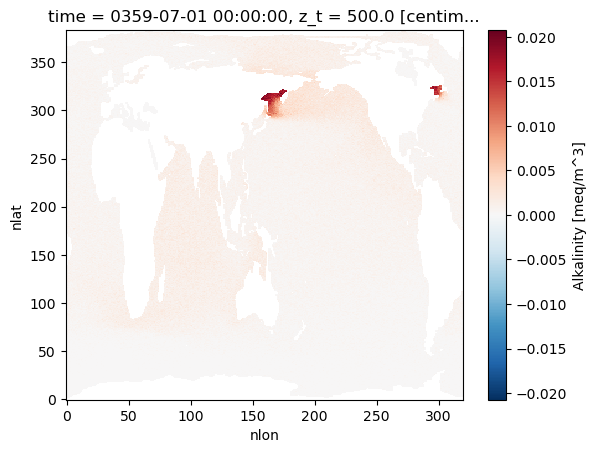

In [17]:
anomalies['ALK_ANOM'].isel(z_t=0).plot();

## Fix encoding

In [18]:
encoded = anomalies.pipe(set_encoding)
encoded

<xarray.Dataset> Size: 355MB
Dimensions:                   (injection_date: 1, elapsed_time: 1, d2: 2,
                               z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60,
                               z_w_bot: 60, nlat: 384, nlon: 320, polygon_id: 1)
Coordinates: (12/64)
    time_bound                (injection_date, elapsed_time, d2) object 16B 0...
    time                      (injection_date, elapsed_time) object 8B 0359-0...
  * z_t                       (z_t) float32 240B 500.0 1.5e+03 ... 5.375e+05
  * z_t_150m                  (z_t_150m) float32 60B 500.0 1.5e+03 ... 1.45e+04
  * z_w                       (z_w) float32 240B 0.0 1e+03 ... 5e+05 5.25e+05
  * z_w_top                   (z_w_top) float32 240B 0.0 1e+03 ... 5.25e+05
    ...                        ...
    sflux_factor              float64 8B ...
    nsurface_t                float64 8B ...
    nsurface_u                float64 8B ...
  * elapsed_time              (elapsed_time) timedelta64[ns] 8B 4441 days
  * polygon_id                (polygon_id) int64 8B 676
  * injection_date            (injection_date) object 8B 1999-04-01 00:00:00
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/31)
    HCO3                      (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    H2CO3                     (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    co3_sat_calc              (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    co3_sat_arag              (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    ALK_RESTORE_TEND          (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    ALK_ALT_CO2_RESTORE_TEND  (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    ...                        ...
    DpCO2_ANOM                (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    DIC_ANOM_zint_100m        (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    ALK_ANOM_zint_100m        (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    tend_zint_100m_DIC_ANOM   (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    tend_zint_100m_ALK_ANOM   (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    STF_ALK_ANOM              (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
Attributes:
    title:             smyle.cdr-atlas-v0.glb-dor_Southern_Ocean_026_1999-04-...
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2025-02-07 at 01:45:37.5
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [19]:
encoded.CO3_ANOM.encoding, encoded['DCO2STAR_ANOM'].encoding

({'zlib': True, 'complevel': 4, 'chunksizes': (1, 1, 1, 60, 384, 320)},
 {'zlib': True, 'complevel': 4, 'chunksizes': (1, 1, 1, 384, 320)})

In [20]:
save_to_netcdf(encoded, out_filepath=f'{scratch}/compressed-anomalies-test.nc')

In [21]:
!du -ch {scratch}/compressed-anomalies-test.nc

89M	/pscratch/sd/a/abanihi/dor/compressed-anomalies-test.nc
89M	total


In [22]:
!du -ch {path}

455M	/global/cfs/projectdirs/m4746/Projects/Ocean-CDR-Atlas-v0/data/archive/smyle.cdr-atlas-v0.glb-dor_Southern_Ocean_026_1999-04-01_02705.001/ocn/hist/smyle.cdr-atlas-v0.glb-dor_Southern_Ocean_026_1999-04-01_02705.001.pop.h.0359-06.nc
455M	total


## Whole pipeline for any task

In [23]:
%%time
out_path_prefix = scratch / "compressed" / "anomalies"

ds = open_compress_and_save_file(nc_files[53], out_path_prefix=out_path_prefix, df=df)
ds

/global/u2/a/abanihi/Ocean-CDR-Atlas-v0/workflows/dor-atlas/process_files.py:160: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = (xr.open_dataset(filepath, engine='netcdf4')



🎉 Processing Complete! 🎉
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📊 Polygon ID:       676
💉 Injection Date:   1999-04
📅 Processed Period: 0351-09
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📁 Input File:
   /global/cfs/projectdirs/m4746/Projects/Ocean-CDR-Atlas-v0/data/archive/smyle.cdr-atlas-v0.glb-dor_Southern_Ocean_026_1999-04-01_02705.001/ocn/hist/smyle.cdr-atlas-v0.glb-dor_Southern_Ocean_026_1999-04-01_02705.001.pop.h.0351-09.nc
📁 Output File:
   /pscratch/sd/a/abanihi/dor/compressed/anomalies/676/04/smyle.cdr-atlas-v0.glb-dor.676-1999-04.pop.h.0351-09.nc
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
✅ File saved successfully!
    
CPU times: user 6.45 s, sys: 1.79 s, total: 8.24 s
Wall time: 7.83 s


PosixPath('/pscratch/sd/a/abanihi/dor/compressed/anomalies/676/04/smyle.cdr-atlas-v0.glb-dor.676-1999-04.pop.h.0351-09.nc')

In [ ]:
%%time

for case in (pbar := tqdm.tqdm(done_cases)):
    pbar.set_description(f"Processing {case}")
    process_case(case=case, base_path=base_directory, out_path_prefix=out_path_prefix, done_cases=done_cases, df=df)

# for case in done_cases:
#     print(f'Processed case: {case} - files processed: {process_case(case=case, base_path=base_directory, out_path_prefix=out_path_prefix, done_cases=done_cases, df=df)}')

Processing smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_021_1999-04-01_00085.001:   4%|▎         | 84/2313 [00:03<01:24, 26.53it/s]

Globbing files (this may take a while)...


Processing smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_021_1999-04-01_00085.001:   4%|▎         | 84/2313 [00:19<01:24, 26.53it/s]

In [ ]:
cluster.close()
client.close()